In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
url = 'E:\App Exes\VS Code\Proyecto Final Data\healthcare-dataset-stroke-data.csv'

In [2]:
df = pd.read_csv(url, sep = ',')
df = pd.get_dummies(df, columns=['work_type'], prefix='work_type')
df = pd.get_dummies(df, columns=['smoking_status'], prefix='smoking_status')
#Reemplaza valores nulos de BMI promediando por rango edades cercanas
promedio_bmi_edades = df.groupby('age')['bmi'].mean()
df['bmi'] = df.apply(lambda row: promedio_bmi_edades[row['age']] if pd.isnull(row['bmi']) else row['bmi'], axis=1)

#Reemplazo valores strings por valores numericos
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0, 'Other': 2})
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1})

df_stroke = df.loc[df['stroke'] == 1]
df_nostroke = df.loc[df['stroke'] == 0]

#Muestro el dataframe completo
df

id  gender   age  hypertension  heart_disease  ever_married  \
0      9046       1  67.0             0              1             1   
1     51676       0  61.0             0              0             1   
2     31112       1  80.0             0              1             1   
3     60182       0  49.0             0              0             1   
4      1665       0  79.0             1              0             1   
...     ...     ...   ...           ...            ...           ...   
5105  18234       0  80.0             1              0             1   
5106  44873       0  81.0             0              0             1   
5107  19723       0  35.0             0              0             1   
5108  37544       1  51.0             0              0             1   
5109  44679       0  44.0             0              0             1   

      Residence_type  avg_glucose_level        bmi  stroke  \
0                  1             228.69  36.600000       1   
1                  0             202.21  30.190000       1   
2                  0             105.92  32.500000       1   
3                  1             171.23  34.400000       1   
4                  0             174.12  24.000000       1   
...              ...                ...        ...     ...   
5105               1              83.75  28.783582       0   
5106               1             125.20  40.000000       0   
5107               0              82.99  30.600000       0   
5108               0             166.29  25.600000       0   
5109               1              85.28  26.200000       0   

      work_type_Govt_job  work_type_Never_worked  work_type_Private  \
0                  False                   False               True   
1                  False                   False              False   
2                  False                   False               True   
3                  False                   False               True   
4                  False                   False              False   
...                  ...                     ...                ...   
5105               False                   False               True   
5106               False                   False              False   
5107               False                   False              False   
5108               False                   False               True   
5109                True                   False              False   

      work_type_Self-employed  work_type_children  smoking_status_Unknown  \
0                       False               False                   False   
1                        True               False                   False   
2                       False               False                   False   
3                       False               False                   False   
4                        True               False                   False   
...                       ...                 ...                     ...   
5105                    False               False                   False   
5106                     True               False                   False   
5107                     True               False                   False   
5108                    False               False                   False   
5109                    False               False                    True   

      smoking_status_formerly smoked  smoking_status_never smoked  \
0                               True                        False   
1                              False                         True   
2                              False                         True   
3                              False                        False   
4                              False                         True   
...                              ...                          ...   
5105                           False                         True   
5106                           False                         True   


In [3]:
def mostrar_imagen(ruta_imagen):
    # Cargar y mostrar la imagen
    imagen = plt.imread(ruta_imagen)
    plt.imshow(imagen)
    plt.axis('off')  # Deshabilitar los ejes
    plt.show()

Introducción:
Los accidentes cerebrovasculares (ACV) son eventos médicos graves que pueden tener consecuencias devastadoras en la vida de las personas. La detección temprana de los factores de riesgo es fundamental para prevenir estos eventos. En este análisis, utilizaremos el dataset "Stroke Prediction Dataset" para explorar las variables relacionadas con pacientes y su propensión a sufrir un ACV. Nuestro objetivo es identificar patrones y desarrollar un modelo predictivo para ayudar en la prevención de accidentes cerebrovasculares.

En esta entrega me voy a centrar mas en los pacientes que sufrieron ACV, esto con el fin de encontrar un patron oculto, ya que la correlacion entre las variables de todo el dataset es bastante baja y la informacion para saber que puede causar un ACV posiblemente se encuentre en donde hay casos de ACV.

¿A quien afecta mas los ACV? ¿Existe algun riesgo segun el genero? ¿La edad es un factor importante?

El dataset contiene información diversa sobre los pacientes. Comenzaremos analizando las características demográficas y de estilo de vida. Observamos que hay una distribución equilibrada de género en el dataset, con aproximadamente la mitad de los pacientes siendo hombres y la otra mitad mujeres. Además, hay una pequeña proporción de pacientes(solo uno) con un género "otro".

Al investigar más a fondo, encontramos que la edad de los pacientes varía ampliamente, desde jóvenes hasta ancianos. Esto nos lleva a explorar la relación entre la edad y los accidentes cerebrovasculares. Encontramos que existe una tendencia general de que el riesgo de ACV aumenta con la edad, lo cual es consistente con la literatura médica.

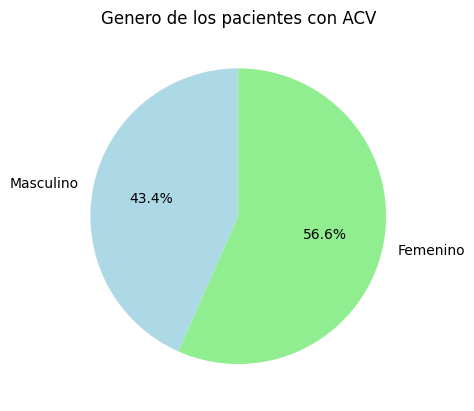

In [4]:
# Cuenta los valores únicos en la columna "ever_married" del DataFrame df_stroke
married_counts = df_stroke['gender'].value_counts()

# Etiquetas y valores para el gráfico de torta
labels = ['Masculino', 'Femenino']
values = [married_counts[1], married_counts[0]]

# Colores para cada sector del gráfico de torta
colors = ['lightblue', 'lightgreen']

# Crea el gráfico de torta
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Genero de los pacientes con ACV')

plt.show()

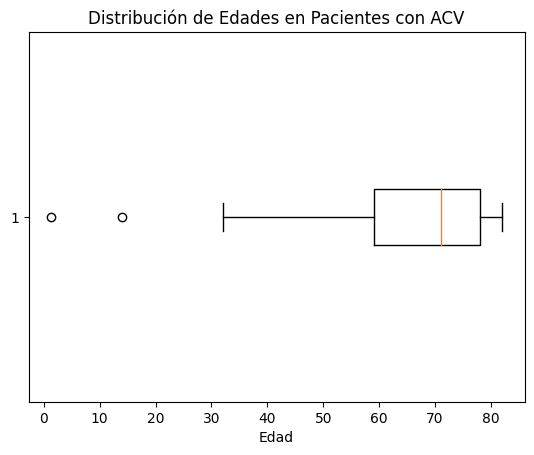

In [5]:
plt.boxplot(df_stroke['age'], vert=False)
plt.xlabel('Edad')
plt.title('Distribución de Edades en Pacientes con ACV')
plt.show()

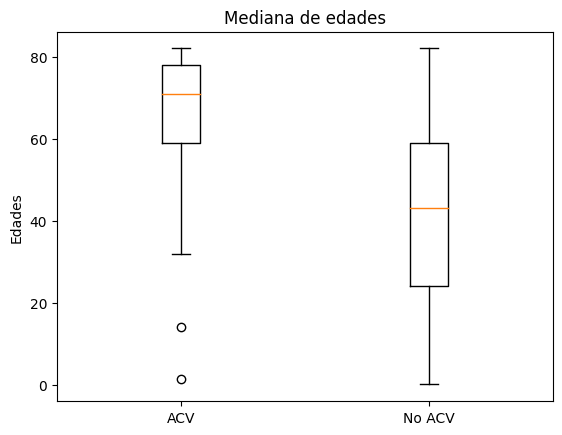

In [6]:
# Crea una lista con los datos de BMI y avr_glucose_level
acv = df_stroke['age']
no_acv = df_nostroke['age']
# Crea una lista con los nombres de las variables
labels = ['ACV', 'No ACV']

# Crea un boxplot con los datos
plt.boxplot([acv, no_acv], labels=labels)
plt.ylabel('Edades')
plt.title('Mediana de edades')

plt.show()

¿Las enfermedades del corazon afecta a los ACV?

Además de la edad, también examinamos otras variables de salud. Observamos que algunos pacientes tienen hipertensión, mientras que otros padecen enfermedades cardiovasculares. Estos factores de riesgo están bien establecidos en la literatura médica y se sabe que contribuyen al desarrollo de accidentes cerebrovasculares. Hay que destacar que de los 5000 pacientes solo 249 sufrieron ACV, este dato aunque pareciera que no son relevantes, de los 249 casos al menos el 60% tienen una de estas caracteristicas.

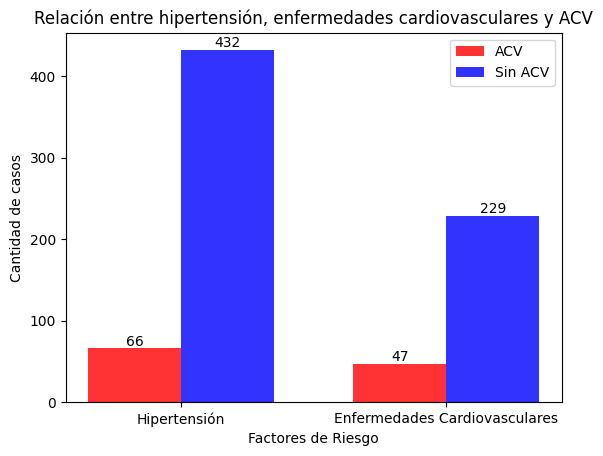

In [7]:
stroke_data = df[df['stroke'] == 1]
no_stroke_data = df[df['stroke'] == 0]

hypertension_stroke = stroke_data[stroke_data['hypertension'] == 1].shape[0]
hypertension_no_stroke = no_stroke_data[no_stroke_data['hypertension'] == 1].shape[0]

heart_disease_stroke = stroke_data[stroke_data['heart_disease'] == 1].shape[0]
heart_disease_no_stroke = no_stroke_data[no_stroke_data['heart_disease'] == 1].shape[0]

# Preparar los datos para el gráfico
stroke_data = [hypertension_stroke, heart_disease_stroke]
no_stroke_data = [hypertension_no_stroke, heart_disease_no_stroke]
x = np.arange(len(stroke_data))

# Ancho de las barras
bar_width = 0.35

# Etiquetas para las barras
labels = ['Hipertensión', 'Enfermedades Cardiovasculares']

# Colores para las barras
colors_stroke = ['red', 'red']
colors_no_stroke = ['blue', 'blue']

# Crear el gráfico de barras
plt.bar(x, stroke_data, width=bar_width, align='center', label='ACV', color=colors_stroke, alpha=0.8)
plt.bar(x + bar_width, no_stroke_data, width=bar_width, align='center', label='Sin ACV', color=colors_no_stroke, alpha=0.8)

# Añadir el valor numérico en cada barra
for i, v in enumerate(stroke_data):
    plt.text(i, v, str(v), color='black', ha='center', va='bottom')
for i, v in enumerate(no_stroke_data):
    plt.text(i + bar_width, v, str(v), color='black', ha='center', va='bottom')

# Configurar las etiquetas de los ejes y el título
plt.xlabel('Factores de Riesgo')
plt.ylabel('Cantidad de casos')
plt.title('Relación entre hipertensión, enfermedades cardiovasculares y ACV')
plt.xticks(x + bar_width/2, labels)
plt.legend()

# Mostrar el gráfico
plt.show()

¿Son las relaciones peligrosas para la salud?

El estado marital y el tipo de residencia también pueden ser factores relevantes en la predicción de los ACV. Al explorar estos datos, encontramos que hay una gran cantidad de pacientes casados que sufrieron ACV. Esto me lleva a pensar que una de las causas sea el estres.

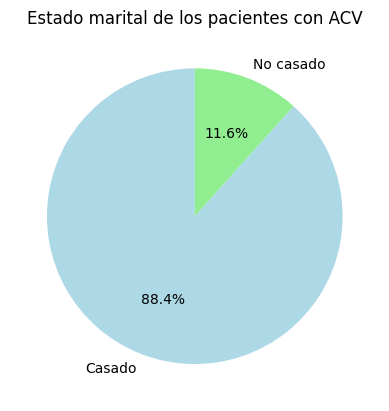

In [8]:
# Cuenta los valores únicos en la columna "ever_married" del DataFrame df_stroke
married_counts = df_stroke['ever_married'].value_counts()

# Etiquetas y valores para el gráfico de torta
labels = ['Casado', 'No casado']
values = [married_counts[1], married_counts[0]]

# Colores para cada sector del gráfico de torta
colors = ['lightblue', 'lightgreen']

# Crea el gráfico de torta
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Estado marital de los pacientes con ACV')

plt.show()

¿Es relevante el tipo de residencia?
La ubicación geográfica de los pacientes, ya sea en áreas urbanas o rurales, podría no influir en su salud en general

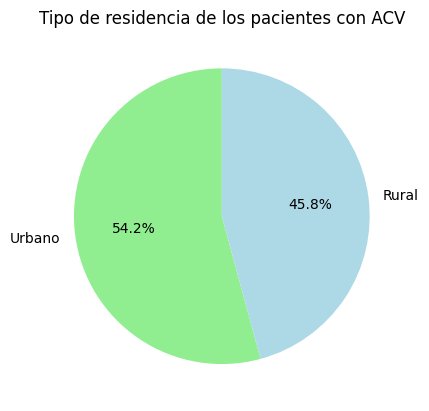

In [9]:
# Cuenta los valores únicos en la columna "Residence_type" del DataFrame df_stroke
residence_counts = df_stroke['Residence_type'].value_counts()

# Etiquetas y valores para el gráfico de torta
labels = ['Urbano', 'Rural']
values = [residence_counts[1], residence_counts[0]]

# Colores para cada sector del gráfico de torta
colors = ['lightgreen', 'lightblue']

# Crea el gráfico de torta
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Tipo de residencia de los pacientes con ACV')

plt.show()

¿Que tanto afecta el estres del trabajo a la salud?

El numero de empleados que sufrieron ACV es significativamente mayor al de empleador, esto podria ser un reflejo del estres que generan los trabajos y sobre todo los jefes hacia los empleados

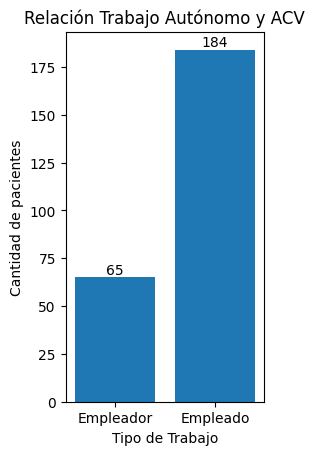

In [10]:
stroke_work = df_stroke['work_type_Self-employed'].value_counts()

labels_work = ['Empleador', 'Empleado']
values_work = [stroke_work[1], stroke_work[0]]

plt.subplot(1, 2, 2)
plt.bar(labels_work, values_work)
plt.xlabel('Tipo de Trabajo')
plt.ylabel('Cantidad de pacientes')
plt.title('Relación Trabajo Autónomo y ACV')
plt.subplots_adjust(wspace=0.5)


for i, v in enumerate(values_work):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

¿Son los fumadores el grupo de riesgo?

En el análisis de variables relacionadas con el estilo de vida, encontramos correlaciones significativas entre el tabaquismo, el trabajo autónomo y el riesgo de ACV. El tabaquismo, un factor de riesgo bien conocido para diversos problemas de salud, también está asociado con un mayor riesgo de accidentes cerebrovasculares. Los pacientes que fumaban y fuman presentaban una mayor incidencia de ACV en comparación con los no fumadores.

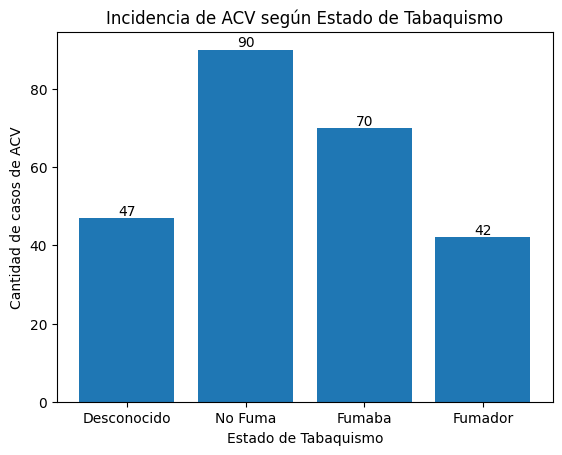

In [11]:
stroke_smoking = df_stroke[['smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']].sum()

labels_smoking = ['Desconocido', 'No Fuma', 'Fumaba', 'Fumador']
values_smoking = [stroke_smoking['smoking_status_Unknown'], stroke_smoking['smoking_status_never smoked'], stroke_smoking['smoking_status_formerly smoked'], stroke_smoking['smoking_status_smokes']]

plt.bar(labels_smoking, values_smoking)

for i, v in enumerate(values_smoking):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Estado de Tabaquismo')
plt.ylabel('Cantidad de casos de ACV')
plt.title('Incidencia de ACV según Estado de Tabaquismo')

plt.show()

Ahora tambien hay que tener en cuenta que la mayoria de los fumadores lo hacen por el estres y muy pocos por socializar y estar en malas condiciones de trabajo o condiciones que generen estres podria llevarte a fumar y aumentar los riesgos de ACV.

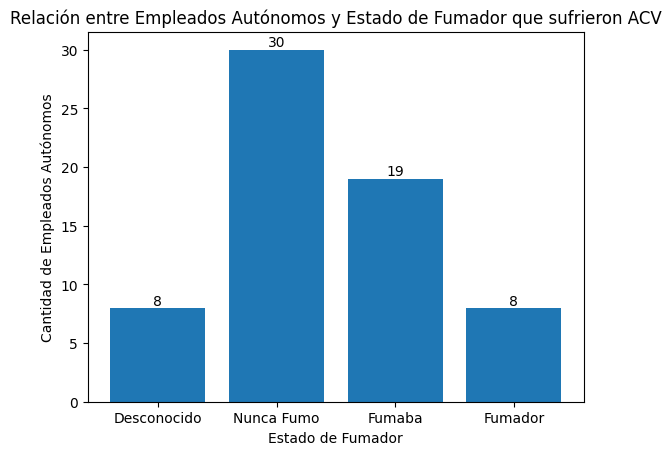

In [12]:
self_employed = df_stroke[df_stroke['work_type_Self-employed'] == 1]

smoking_counts = self_employed[['smoking_status_Unknown', 'smoking_status_never smoked', 'smoking_status_formerly smoked', 'smoking_status_smokes']].sum()

labels = ['Desconocido', 'Nunca Fumo', 'Fumaba', 'Fumador']

values = [smoking_counts['smoking_status_Unknown'], smoking_counts['smoking_status_never smoked'], smoking_counts['smoking_status_formerly smoked'], smoking_counts['smoking_status_smokes']]

plt.bar(labels, values)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Estado de Fumador')
plt.ylabel('Cantidad de Empleados Autónomos')
plt.title('Relación entre Empleados Autónomos y Estado de Fumador que sufrieron ACV')

plt.show()

¿Son los estudios de BMI y Glucosa en sangre factores para predecir el ACV? ¿Afecta el tabaquismo a estos mismos?

Por ultimo investigamos los datos sobre la salud en cuestion de peso relacionado con la altura(BMI) y azucar en sangre(Niveles de glucosa) se cree que los niveles altos de glucosa se relacionan con los fumadores. Se puede notar que el BMI en ambos casos(ACV y No ACV) es similar, pero los niveles de glucosa en los casos de ACV son mayores, segun investigaciones medicas esto puede ser generado por ser fumador.

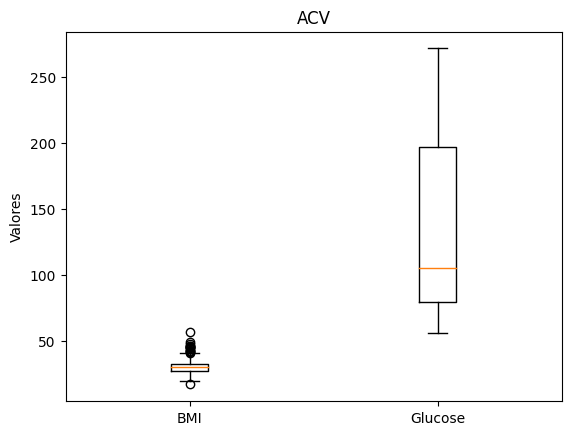

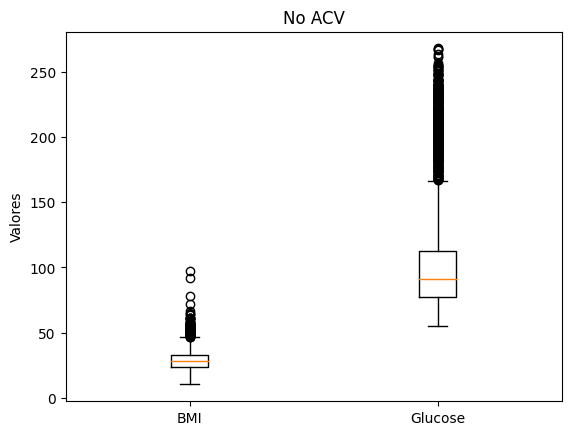

In [13]:
bmi_data = df_stroke['bmi']
glucose_data = df_stroke['avg_glucose_level']

# Crea una lista con los nombres de las variables
labels = ['BMI', 'Glucose']

# Crea un boxplot con los datos
plt.boxplot([bmi_data, glucose_data], labels=labels)
plt.ylabel('Valores')
plt.title('ACV')

plt.show()

bmi_data = df_nostroke['bmi']
glucose_data = df_nostroke['avg_glucose_level']

# Crea una lista con los nombres de las variables
labels = ['BMI', 'Glucose']

# Crea un boxplot con los datos
plt.boxplot([bmi_data, glucose_data], labels=labels)
plt.ylabel('Valores')
plt.title('No ACV')

plt.show()

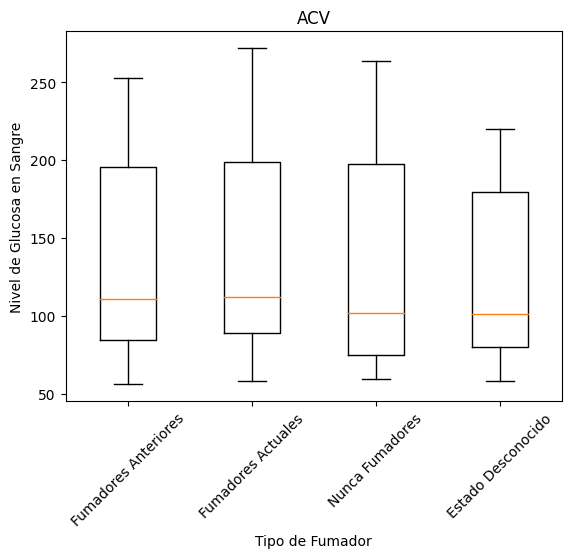

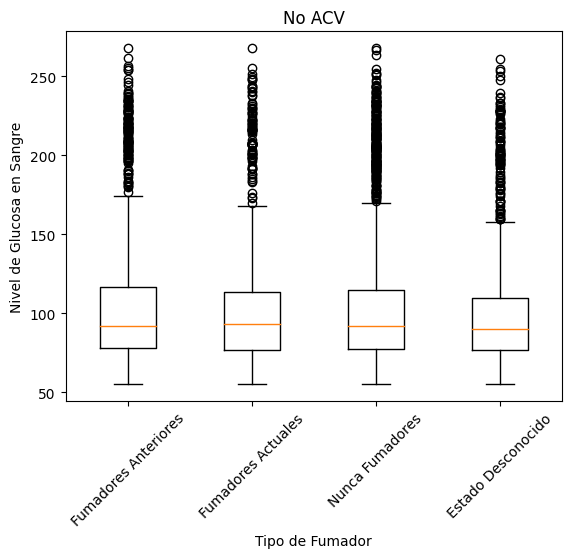

In [14]:
# Filtrar el DataFrame por cada tipo de fumador
former_smokers = df_stroke[df_stroke['smoking_status_formerly smoked'] == 1]
current_smokers = df_stroke[df_stroke['smoking_status_smokes'] == 1]
never_smokers = df_stroke[df_stroke['smoking_status_never smoked'] == 1]
unknown_smokers = df_stroke[df_stroke['smoking_status_Unknown'] == 1]

# Crear una lista con los datos de glucosa para cada tipo de fumador
data = [former_smokers['avg_glucose_level'],
        current_smokers['avg_glucose_level'],
        never_smokers['avg_glucose_level'],
        unknown_smokers['avg_glucose_level']]

# Etiquetas para el gráfico
labels = ['Fumadores Anteriores', 'Fumadores Actuales', 'Nunca Fumadores', 'Estado Desconocido']

# Crear el gráfico de caja
plt.boxplot(data, labels=labels)
plt.xlabel('Tipo de Fumador')
plt.ylabel('Nivel de Glucosa en Sangre')
plt.title('ACV')
plt.xticks(rotation=45)

plt.show()

# Filtrar el DataFrame por cada tipo de fumador
former_smokers = df_nostroke[df_nostroke['smoking_status_formerly smoked'] == 1]
current_smokers = df_nostroke[df_nostroke['smoking_status_smokes'] == 1]
never_smokers = df_nostroke[df_nostroke['smoking_status_never smoked'] == 1]
unknown_smokers = df_nostroke[df_nostroke['smoking_status_Unknown'] == 1]

# Crear una lista con los datos de glucosa para cada tipo de fumador
data = [former_smokers['avg_glucose_level'],
        current_smokers['avg_glucose_level'],
        never_smokers['avg_glucose_level'],
        unknown_smokers['avg_glucose_level']]

# Etiquetas para el gráfico
labels = ['Fumadores Anteriores', 'Fumadores Actuales', 'Nunca Fumadores', 'Estado Desconocido']

# Crear el gráfico de caja
plt.boxplot(data, labels=labels)
plt.xlabel('Tipo de Fumador')
plt.ylabel('Nivel de Glucosa en Sangre')
plt.title('No ACV')
plt.xticks(rotation=45)

plt.show()

Riesgo de ACV: En el dataset, se encontró que solo una minoría de los pacientes ha experimentado un accidente cerebrovascular (ACV). Esto resalta la importancia de los esfuerzos de prevención y la necesidad de identificar los factores de riesgo asociados.

Variables demográficas: Se encontro que en los pacientes que tuvieron un ACV estaban en su mayoria casados. La ubicación geográfica de los pacientes (áreas urbanas o rurales) no solto informacion util.

Estilo de vida: A través del análisis de variables relacionadas con el estilo de vida, se encontraron correlaciones significativas entre el tabaquismo, el trabajo autónomo y el riesgo de ACV.

Factores de salud: No se observó una correlación entre niveles altos de índice de masa corporal (BMI) y los ACV, pero si que la mediana del nivel de glucosa es un poco mayor. Creo que los niveles altos de azucar pueden estar relacionados de alguna forma.

En resumen:

La teoria principal es que existe una fuerte correlacion entre variables como estar casado, ser empleado, hipertension, enfermedades del corazon, fumar y los niveles altos de glucosa. Todas estas variables se ralacionan entre si con el estres, lamentablemente no hay una forma de medir el estres y si existe no estan los datos para estudiarlos en el dataset pero el estres podria ser la principal causa de los ACV.